In [212]:
import sys
import os
sys.path.insert(0, os.path.expanduser('~/covid19_spread'))
import pandas
import plotly.express as px
import sqlite3
from forecast_db import DB
import yaml
from datetime import timedelta
from IPython.display import SVG, display
import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
conn_ = sqlite3.connect(DB)
conn = sqlite3.connect(':memory:')
conn_.backup(conn)

In [214]:
loc_map = {
    'new-jersey': {'loc1': 'United States', 'loc2': 'New Jersey'},
    'nystate': {'loc1': 'United States', 'loc2': 'New York'},
    'at': {'loc1': 'Austria'}
}

In [215]:
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_11_09_05/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_22_11_08/forecasts/forecast_best_mae.csv'

forecast_pth = os.environ.get('FORECAST_PTH', forecast_pth)

cfg = yaml.safe_load(open(os.path.dirname(forecast_pth) + '/../cfg.yml'))
df = pandas.read_csv(forecast_pth, index_col='date', parse_dates=['date'])
var_name = f'loc{len(loc_map[cfg["region"]]) + 1}'
df = df.reset_index().melt(id_vars=['date'], value_name='counts', var_name=var_name)
for k, v in loc_map[cfg['region']].items():
    df[k] = v

df['id'] = 'this_forecast'
df['forecast_date'] = (df['date'].min() - timedelta(days=1)).date()
df.to_sql('infections', conn, if_exists='append', index=False)
basedate = (df['date'].min() - timedelta(days=1)).date()

In [216]:
cond = ' AND '.join([f"{k}='{v}'" for k, v in loc_map[cfg['region']].items()])
cond += f' AND loc{len(loc_map[cfg["region"]]) + 1} IS NOT NULL'
cond

"loc1='Austria' AND loc2 IS NOT NULL"

In [217]:
dates = ', '.join([f"'{d}'" for d in df['date'].dt.date.unique()])
q = f"""
SELECT loc1, loc2, loc3, date, id, counts, forecast_date
FROM infections
WHERE {cond} 
    AND date >= '{basedate - timedelta(days=7)}'
    AND forecast_date >= '{basedate - timedelta(days=7)}' 
    AND forecast_date <= '{basedate}' 
"""
forecasts = pandas.read_sql(q, conn, parse_dates=['date', 'forecast_date'])
forecasts['forecast_date'] = forecasts['forecast_date'].dt.date
ref = pandas.read_sql("SELECT * FROM infections WHERE id='nyt_ground_truth'", conn, parse_dates=['date', 'forecast_date'])


In [218]:
group_loc = f'loc{len(loc_map[cfg["region"]])}'
grouped = forecasts.groupby([group_loc, 'id', 'forecast_date', 'date']).sum().reset_index()
grouped['color'] = grouped['forecast_date'].apply(str) + '_' + grouped['id']

# Forecast Trajectories

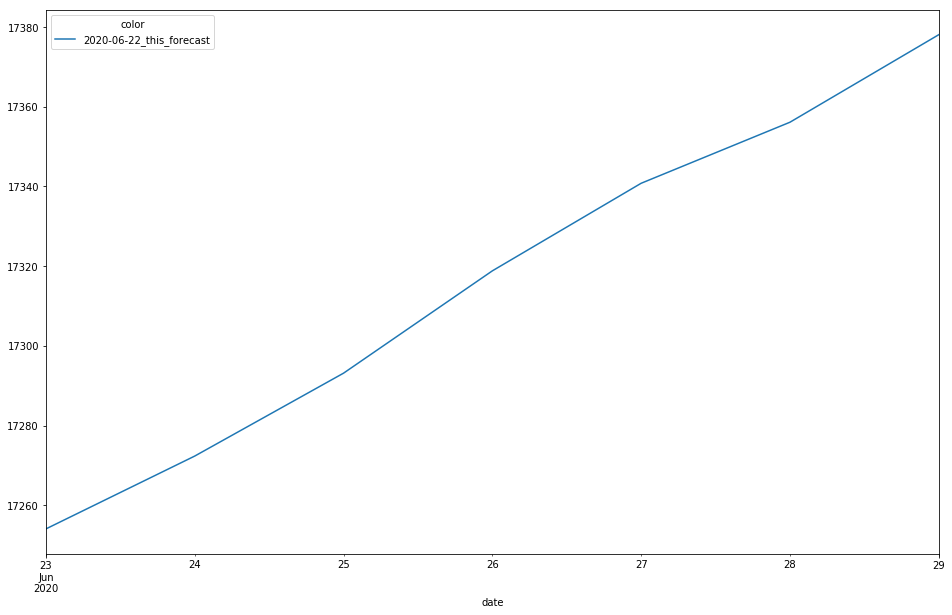

In [219]:
fig = grouped.pivot(index='date', columns='color', values='counts').plot(figsize=(16, 10))

# Mean Absolute Error

In [220]:
merged = forecasts.merge(ref, on=['loc2', 'loc3', 'date'], suffixes=('_forecast', '_gt'))
merged['diff'] = (merged['counts_forecast'] - merged['counts_gt']).abs()
mae = merged.groupby(['forecast_date_forecast', 'id_forecast'])['diff'].mean().reset_index()
mae = mae.rename(columns={'forecast_date_forecast': 'forecast_date', 'id_forecast': 'model_id', 'diff': 'mae'})
display(mae.sort_values(by=['forecast_date', 'model_id']))

,forecast_date,model_id,mae
